In [9]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
data=pd.read_csv('META.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


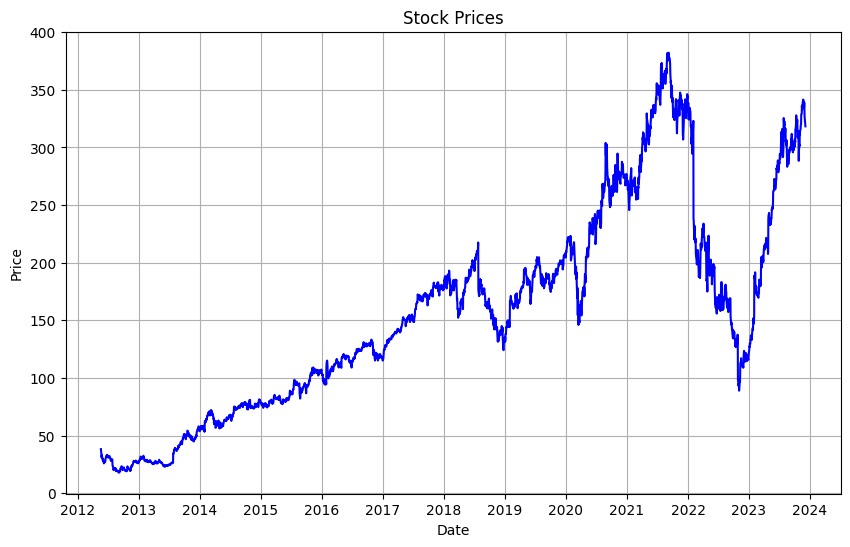

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
plt.figure(figsize=(10,6))
plt.plot(data.index,data['Close'],label='Close price',color='Blue')
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display year-month format
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks for each year
plt.grid(True)
plt.show()

In [12]:
missing_values=data.isnull().sum()
print(missing_values)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(data['Close'].values.reshape(-1,1))
print(scaled_data)

[[0.05624914]
 [0.04472493]
 [0.03641103]
 ...
 [0.84261219]
 [0.82944161]
 [0.82469479]]


In [14]:
#we need to split the data to create sequences for input to rnn
sequence_length=30
train_size=int(len(scaled_data)*0.8)
train_data=scaled_data[:train_size]
test_data=scaled_data[train_size:]

In [15]:
def create_sequences(data,seq_length):
    sequences=[]
    targets=[]
    for i in range(seq_length,len(data)):
        sequences.append(data[i-seq_length:i,0])
        targets.append(data[i,0])
    return np.array(sequences),np.array(targets)
X_train,y_train=create_sequences(train_data,sequence_length)
X_test,y_test=create_sequences(test_data,sequence_length)
print(X_train.shape)
print(X_test.shape)

(2294, 30)
(552, 30)


In [16]:
# Reshape the input data for RNN (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Adding 1 for the feature dimension
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the RNN model
model = Sequential()

# Adding the GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # Input shape: (time steps, features)
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Adding a second GRU layer
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units=1))  # Predicting the next day's price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50


/Users/deekshak/Documents/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0410
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0022
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 15/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010
Epoch 16/50
72/

In [17]:
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predicted values
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values (y_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - actual_prices) ** 2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate percentage error (optional)
percentage_error = np.abs((predictions - actual_prices) / actual_prices) * 100
mean_percentage_error = np.mean(percentage_error)
print(f"Mean Percentage Error: {mean_percentage_error:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Root Mean Squared Error (RMSE): 8.893386074963479
Mean Percentage Error: 2.95%


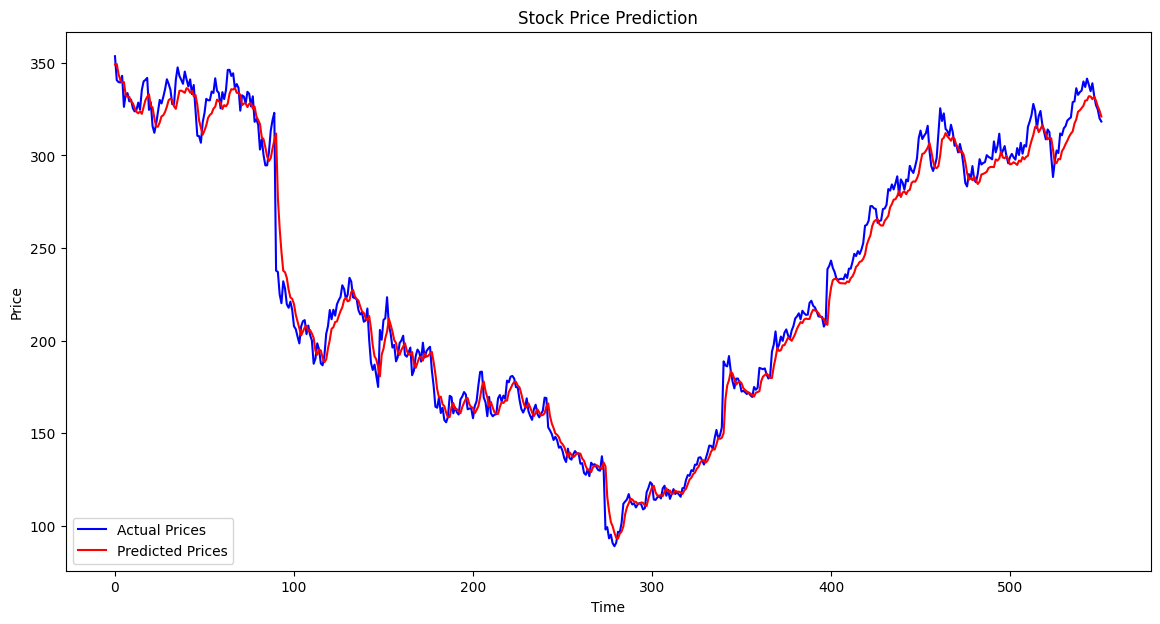

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()